In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as ns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram,linkage
import warnings
warnings.filterwarnings("ignore")

# 1-)Veri Seti Oluşturma


In [82]:
def create_customer_dataset(n_customers=500):
    segments={
        "Premium":{
            "count":int(n_customers*0.15),
            "annual_spending":(5000,15000),
            "frequency":(20,50),
            "recency":(1,15),
            "avg_order":(200,500),
            "products_purchased":(50,150),
            "returns_rate":(0.02,0.08)
        },
        "Regular":{
            "count":int(n_customers*0.35),
            "annual_spending":(1000,5000),
            "frequency":(5,20),
            "recency":(10,45),
            "avg_order":(50,200),
            "products_purchased":(10,50),
            "returns_rate":(0.05,0.15)
        },
        "Occasional":{
            "count":int(n_customers * 0.30),
            "annual_spending":(200,1000),
            "frequency":(1,5),
            "recency":(30,90),
            "avg_order":(30,100),
            "products_purchased":(3,15),
            "returns_rate":(0.10,0.25)
        },
        "Dormant":{
            "count":int(n_customers * 0.20),
            "annual_spending":(0,200),
            "frequency":(0,2),
            "recency":(90,365),
            "avg_order":(20,50),
            "products_purchased":(1,5),
            "returns_rate":(0.15,0.35)
        }
    }

    data=[]
    customer_id=1000

    for segment_name,params in segments.items():
        for _ in range(params["count"]):
            customer={
                "customer_id":f"CUST_{customer_id}",
                "annual_spending":np.random.uniform(*params["annual_spending"]),
                "purchase_frequency":np.random.randint(*params["frequency"]),
                "days_since_last_purchase":np.random.randint(*params["recency"]),
                "avg_order_value":np.random.uniform(*params["avg_order"]),
                "total_products_purchased":np.random.randint(*params["products_purchased"]),
                "return_rate":np.random.uniform(*params["returns_rate"]),
                "true_segment":segment_name
            }

            #Ekstra özellikler
            customer["customer_lifetime_days"]=np.random.randint(30,1500)
            customer["email_open_rate"]=np.random.uniform(0.1,0.7) if segment_name != "Dormant" else np.random.uniform(0,0.2)
            customer["mobile_app_usage"]=np.random.choice([0,1],p=[0.3,0.7] if segment_name == "Premium" else [0.6,0.4])


            data.append(customer)
            customer_id +=1


    df=pd.DataFrame(data)

    #Veri setini karıştır

    df=df.sample(frac=1,random_state=42).reset_index(drop=True)

    return df


print("Veri seti oluşturuluyor")
df=create_customer_dataset(500)

print(f"Veri seti boyutu: {df.shape}")
print(f"Özellikler: {list(df.columns)}")
print("\nİlk 5 kayıt:")
print(df.head())
print("\nVeri seti istatistikleri:")
print(df.describe())    

Veri seti oluşturuluyor
Veri seti boyutu: (500, 11)
Özellikler: ['customer_id', 'annual_spending', 'purchase_frequency', 'days_since_last_purchase', 'avg_order_value', 'total_products_purchased', 'return_rate', 'true_segment', 'customer_lifetime_days', 'email_open_rate', 'mobile_app_usage']

İlk 5 kayıt:
  customer_id  annual_spending  purchase_frequency  days_since_last_purchase  \
0   CUST_1361       739.666801                   3                        82   
1   CUST_1073     14817.083840                  43                         5   
2   CUST_1374       475.241685                   3                        77   
3   CUST_1155      3371.740729                   5                        30   
4   CUST_1104      3002.305412                  15                        10   

   avg_order_value  total_products_purchased  return_rate true_segment  \
0        80.844831                         3     0.181365   Occasional   
1       424.778461                        90     0.020365      Pr

In [83]:
df

,customer_id,annual_spending,purchase_frequency,days_since_last_purchase,avg_order_value,total_products_purchased,return_rate,true_segment,customer_lifetime_days,email_open_rate,mobile_app_usage
0,CUST_1361,739.666801,3,82,80.844831,3,0.181365,Occasional,1412,0.262044,1
1,CUST_1073,14817.083840,43,5,424.778461,90,0.020365,Premium,1105,0.349530,1
2,CUST_1374,475.241685,3,77,56.120565,14,0.152229,Occasional,1056,0.600292,0
3,CUST_1155,3371.740729,5,30,69.170777,12,0.137350,Regular,898,0.452397,1
4,CUST_1104,3002.305412,15,10,194.268538,27,0.116821,Regular,1093,0.675439,0
...,...,...,...,...,...,...,...,...,...,...,...
495,CUST_1106,2249.820918,6,41,112.674760,40,0.134122,Regular,120,0.696309,1
496,CUST_1270,515.139954,3,45,73.566431,7,0.188881,Occasional,49,0.484124,0
497,CUST_1348,378.376147,2,84,56.408482,12,0.176620,Occasional,158,0.217664,0
498,CUST_1435,4.113243,0,270,25.902691,2,0.267255,Dormant,391,0.136058,1


# 2-) Veri Ön İşleme

In [84]:
#Sayısal özellikleri seç
feature_columns=["annual_spending","purchase_frequency","days_since_last_purchase",
                 "avg_order_value","total_products_purchased","return_rate","customer_lifetime_days","email_open_rate"]

X=df[feature_columns]

### Veriyi standartlaştır

In [85]:
sc=StandardScaler()
X_scaled=sc.fit_transform(X)

print(f"Ölçeklendirme öncesi veri aralığı: Min={X.min().min():.2f}, Max={X.max().max():.2f}")
print(f"Ölçeklendirme sonrası veri aralığı: Min={X_scaled.min():.2f}, Max={X_scaled.max():.2f}")

Ölçeklendirme öncesi veri aralığı: Min=0.00, Max=14922.93
Ölçeklendirme sonrası veri aralığı: Min=-1.73, Max=3.82


# KMeans Kümelemesi

In [86]:
#optimal k değerini bulmak için elbow methodu kullan
inertias=[]
silhouette_scores=[]
k_range=range(2,11)

for k in k_range:
    kmeans=KMeans(n_clusters=k,random_state=42,n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled,kmeans.labels_))

### Görselleştirme

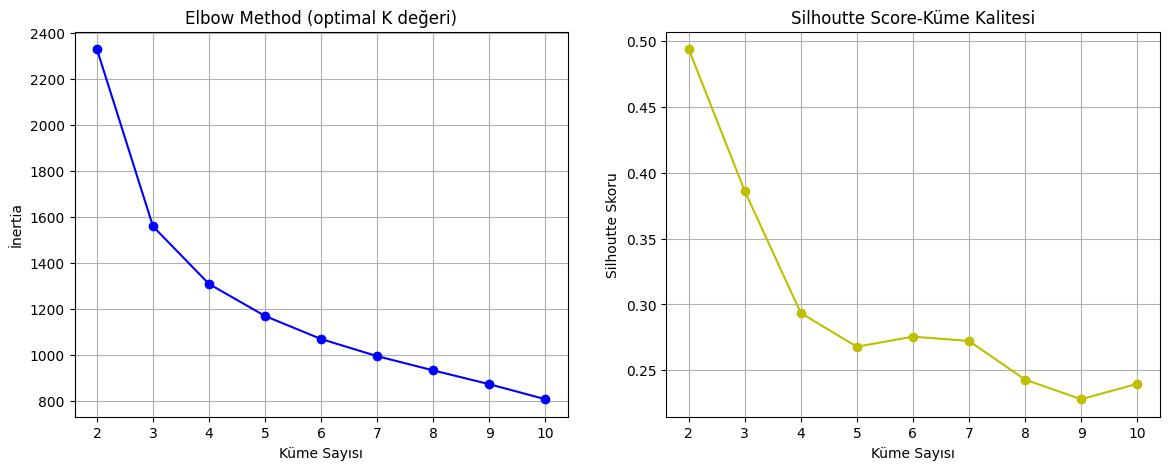

In [87]:
fig,ax=plt.subplots(1,2,figsize=(14,5))

#Elbow methodu
ax[0].plot(k_range,inertias,"bo-")
ax[0].set_xlabel("Küme Sayısı")
ax[0].set_ylabel("İnertia")
ax[0].set_title("Elbow Method (optimal K değeri)")
ax[0].grid(True)

#Silhoutte Score
ax[1].plot(k_range,silhouette_scores,"yo-")
ax[1].set_xlabel("Küme Sayısı")
ax[1].set_ylabel("Silhoutte Skoru")
ax[1].set_title("Silhoutte Score-Küme Kalitesi")
ax[1].grid(True)

plt.show()

In [88]:
# En iyi K değeri = 3
optimal_k=3
kmeans_final=KMeans(n_clusters=optimal_k,random_state=42,n_init=10)
kmeans_labels=kmeans_final.fit_predict(X_scaled)

df["kmeans_cluster"]=kmeans_labels

print(f"Optimal küme sayısı: {optimal_k}")
print(f"Silhoutte Skor: {silhouette_score(X_scaled,kmeans_labels):.2f}")
print(f"Kümelerdeli müşteri sayıları: ")
print(df["kmeans_cluster"].value_counts().sort_index())

Optimal küme sayısı: 3
Silhoutte Skor: 0.39
Kümelerdeli müşteri sayıları: 
kmeans_cluster
0    105
1     75
2    320
Name: count, dtype: int64


### Küme merkezlerini analiz et

In [89]:
cluster_centers=sc.inverse_transform(kmeans_final.cluster_centers_)
cluster_df=pd.DataFrame(cluster_centers,columns=feature_columns)
cluster_df["cluster"]=range(optimal_k)

print("Küme Merkezleri ")
print(cluster_df.round(2))

Küme Merkezleri 
   annual_spending  purchase_frequency  days_since_last_purchase  \
0           126.28                0.66                    207.88   
1          9164.13               34.33                      7.20   
2          1853.24                7.57                     41.84   

   avg_order_value  total_products_purchased  return_rate  \
0            36.23                      2.87         0.25   
1           344.48                    100.33         0.05   
2            97.42                     20.52         0.14   

   customer_lifetime_days  email_open_rate  cluster  
0                  794.61             0.10        0  
1                  810.00             0.37        1  
2                  744.13             0.40        2  


# 4-) Hiyerarşik Kümeleme

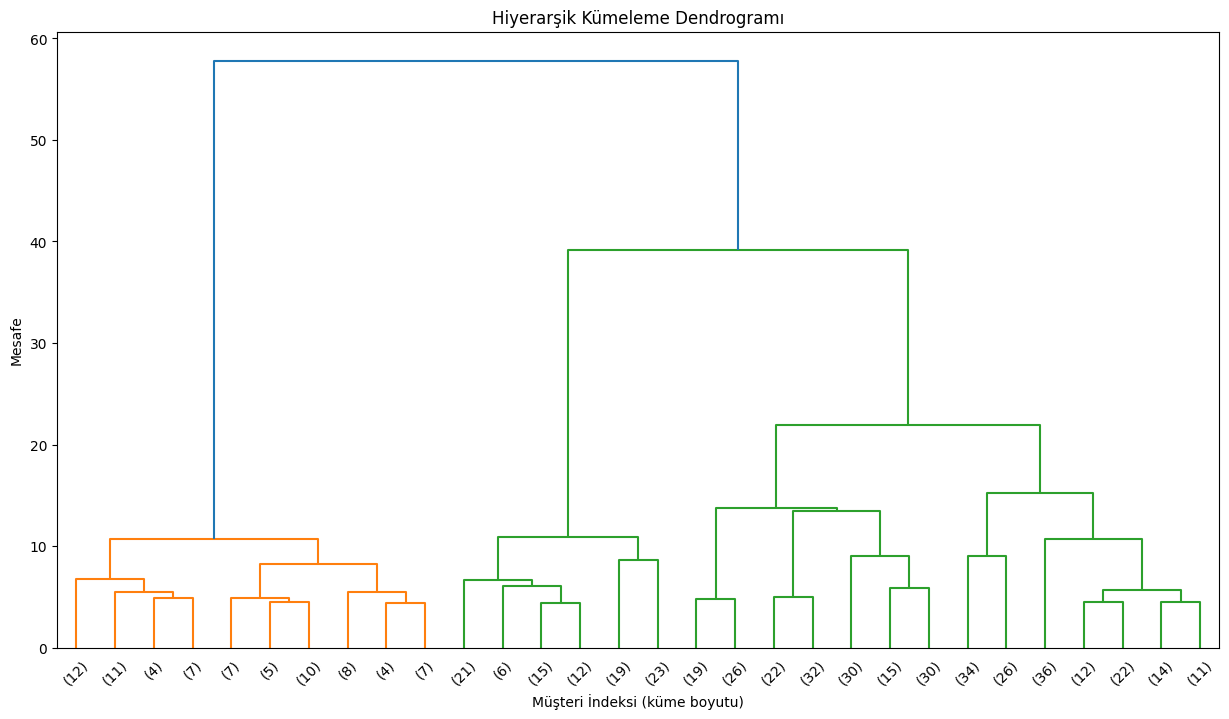

In [90]:
# Linkage matrisi oluştur
linkage_matrix=linkage(X_scaled,method="ward")

#Dendrogram
plt.figure(figsize=(15,8))
dendrogram(linkage_matrix,
           truncate_mode="lastp",
           p=30,show_leaf_counts=True,
           leaf_font_size=10)

plt.title("Hiyerarşik Kümeleme Dendrogramı")
plt.xlabel("Müşteri İndeksi (küme boyutu)")
plt.ylabel("Mesafe")
plt.show()